# $H \rightarrow ZZ \rightarrow 4\ell$ (VBF vs. ggF) exercise
 >__Created__:  2018 Harrison B. Prosper


### Exercise
  1. Build deep network, using __MLPClassifier__, to discriminate between the Higgs boson production in the vector boson fusion mode from its production via gluon-gluon fusion.  $\Delta\eta_{jj}, m_{jj})$, which in the dataframe are $detajj$ and $massjj$, respectively
  1. Try one and two hidden layers.
  1. Vary the number of nodes/layer

In [2]:
import os, sys
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.externals import joblib

import matplotlib as mp
import matplotlib.pyplot as plt
import pylab as pl

%matplotlib inline

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
# update fonts
FONTSIZE = 18
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 18}

mp.rc('font', **font)

### Load Higgs boson data into memory


In [4]:
train_data, test_data = joblib.load('higgs_vbf_ggf_data.pkl')
train_data[['target','detajj', 'massjj', 'pt4l']][:20]

,target,detajj,massjj,pt4l
43039,0.0,0.6752,126.50,289.20
22797,0.0,0.5136,88.57,206.80
12275,0.0,0.4628,31.48,81.36
56449,0.0,2.9970,183.10,48.36
16263,1.0,5.4500,660.50,48.08
31487,0.0,1.2710,242.20,208.80
327,1.0,4.7330,996.10,94.63
12030,0.0,4.7870,432.90,49.50
11087,1.0,5.2510,619.20,118.70
41137,0.0,1.5700,175.00,199.60


### Prepare data for training/testing

In [5]:
def standardize_data(train_data, test_data, 
                     inputs  = ['detajj', 
                                'massjj']):
    scaler  = StandardScaler()
    scaler.fit(train_data[inputs])
    
    X_train = scaler.transform(train_data[inputs])
    X_test  = scaler.transform(test_data[inputs])
    y_train = train_data['target']
    y_test  = test_data['target']

    return (X_train, X_test, y_train, y_test, scaler)

In [6]:
inputs = ['detajj', 'massjj']
X_train, X_test, y_train, y_test, scaler = standardize_data(train_data, test_data, inputs)

### Plot training standardized data

In [7]:
def splitData(X, y, names, N=-1):
    # create an empty "table"
    ncols = len(names)
    s = '[],'*ncols
    s = '[%s]' % s[:-1]
    sig = eval(s)
    bkg = eval(s)
 
    for i in range(len(y)):
        if y.iloc[i]:
            bag = sig # this is a reference (not a copie!)
        else:
            bag = bkg
            
        for c in range(ncols):
            bag[c].append(X[i][c])

        if N < 0: continue
        if len(sig) < N: continue
        if len(bkg) < N: continue
        break
        
    # create dataframes
    columns = {}
    for name in names:
        columns[name] = []
    sigdf = pd.DataFrame(columns)
    bkgdf = pd.DataFrame(columns)
    for i, name in enumerate(names):
        sigdf[name] = sig[i]
        bkgdf[name] = bkg[i]
    return (bkgdf, sigdf)

def plotData(bkg, sig, xmin=-3, xmax=3.0, ymin=-1.5, ymax=1.5, ftsize=FONTSIZE):
    # set size of figure
    plt.figure(figsize=(8,8));

    # get axis info
    axes = plt.gca()
    # set axes' limits
    axes.set_xlim(xmin, xmax)
    axes.set_ylim(ymin, ymax)
    
    # annotate axes
    plt.xlabel(r'$\Delta\eta_{jj}$', fontsize=ftsize)
    plt.ylabel(r'$m_{jj}$', fontsize=ftsize)
    
    # choose color of points
    red = (1,0,0)
    blue= (0,0,1)
    plt.scatter(sig['detajj'], sig['massjj'], marker='o',
                s=50, c=blue, alpha=0.2, label=r'$H \rightarrow ZZ \rightarrow 4\ell$ (VBF)')
    pl.legend(loc='upper left', fontsize='small') # activate legend
    
    plt.scatter(bkg['detajj'], bkg['massjj'], marker='*',
                s=100, c=red,  alpha=0.2, label=r'$H \rightarrow ZZ \rightarrow 4\ell$ (ggF)')
    pl.legend(loc='upper left', fontsize='small') # activate legend
    
    plt.savefig('02_dnn_higgs_vbf_ggf_standardized.png')
    plt.show()

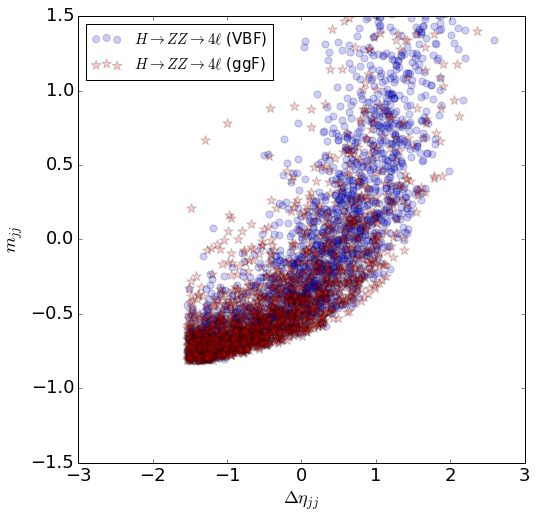

In [8]:
bkg, sig = splitData(X_train, y_train, inputs)
N = 2000
plotData(bkg[:N], sig[:N])

### Define function space

In [9]:
mlp = MLPClassifier(hidden_layer_sizes=(10,10), 
                    max_iter=500, 
                    alpha=1e-3,
                    solver='adam', 
                    verbose=0, 
                    tol=1e-6, 
                    warm_start=False,
                    random_state=1)

# possible combinations of params
params = {'max_iter': [500, 800],
          'hidden_layer_sizes': [(5,5), (8, 8)],
          'alpha': [1e-3,2e-3,4e-3,8e-3],
          'solver' : ['sgd', 'adam']}

### Train classifier

In [12]:
print "*** TRAINING ***"
#rcv = RandomizedSearchCV(dnn, params, n_iter=25, verbose=1)
#rcv.fit(X_train, y_train)

#print "Best set of parameters: %s" % rcv.best_params_
#dnn= rcv.best_estimator_

dnn.fit(X_train, y_train)

print("Training set score: %f" % dnn.score(X_train, y_train))      
print("Test set score:     %f" % dnn.score(X_test,  y_test))

filename = '02_dnn_higgs_vbf_ggf.pkl'
print "save to %s" % filename
joblib.dump([dnn, scaler], filename)

*** TRAINING ***
Training set score: 0.695920
Test set score:     0.687600
save to 02_dnn_higgs_vbf_ggf.pkl


['02_dnn_higgs_vbf_ggf.pkl']

### Plot loss curve vs. epochs

In [13]:
def plotLoss(mlp, ftsize=FONTSIZE):
    y    = mlp.loss_curve_
    x    = np.array(range(len(y)))+1

    ymin = 0.8*min(y)
    ymax = 1.2*max(y)
    epoch= range(len(y))
    xmin = 0
    xmax = len(x)
    
    # set size of figure
    plt.figure(figsize=(8,4));

    # get axis info
    axes = plt.gca()
    # set axes' limits
    axes.set_xlim(xmin, xmax)
    axes.set_ylim(ymin, ymax)
    
    # annotate axes
    plt.xlabel(r'epoch', fontsize=ftsize)
    plt.ylabel(r'loss',  fontsize=ftsize)
    
    # choose color of points
    plt.plot(x, y, 'b-')
    plt.savefig('02_dnn_higgs_vbf_ggf_loss.png')
    plt.show()

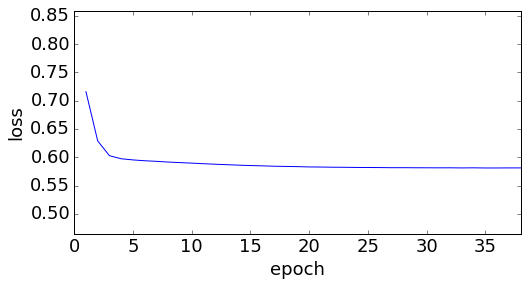

In [15]:
plotLoss(dnn)

In [19]:
def plotDistribution(mlp, X_test, y_test, ftsize=FONTSIZE, fgsize=(12,8)):

    # returns (prob(class1), prob(class2))
    p = mlp.predict_proba(X_test)
        
    b = map(lambda x: x[0][-1], filter(lambda x: x[-1], zip(p, y_test < 1)))
    
    s = map(lambda x: x[0][-1], filter(lambda x: x[-1], zip(p, y_test > 0)))  
        
    # set size of figure
    plt.figure(figsize=fgsize)
    
    plt.hist(b, 
             bins=50, 
             color=(1,0,0),
             alpha=0.3,
             range=(0,1), 
             normed=True, 
             label=r'$H \rightarrow ZZ \rightarrow 4\ell$ (ggF)') 
    pl.legend(fontsize='small') # show legend using specified "label"
    
    plt.hist(s, 
             bins=50, 
             color=(0,1,0),
             alpha=0.3,
             range=(0,1), 
             normed=True, 
             label=r'$H \rightarrow ZZ \rightarrow 4\ell$ (VBF)')
    pl.legend(fontsize='small') # show legend using specified "label"
       
    # adjust y limits
    axes = plt.gca()
    ymin, ymax = axes.get_ylim()
    delta = 0.2
    ii = int(1.3*ymax/delta)
    ymax = ii * 0.2
    axes.set_ylim((0, ymax))
    plt.savefig("02_dnn_hzz_vbf_ggf_distribution.png")
    plt.show()

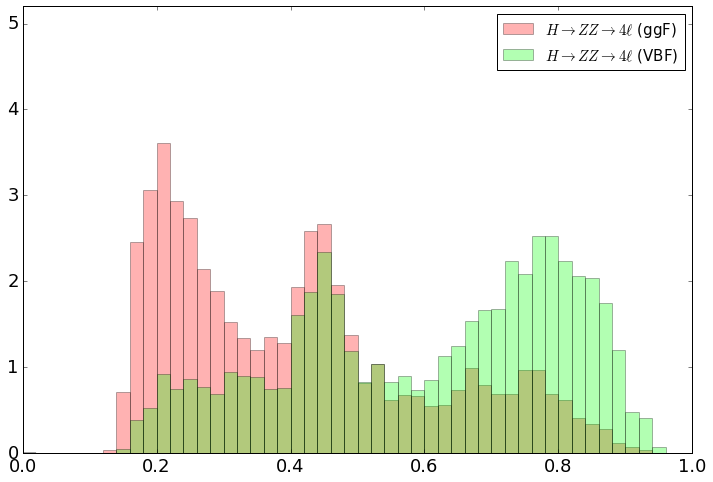

In [20]:
plotDistribution(dnn, X_test, y_test)

In [30]:
def plotResults(mlp, scaler, train_data, test_data, 
                xmin=0, xmax=8, ymin=0, ymax=2000, N=2000,
                ftsize=FONTSIZE):
    
    # split into sig and bkg for the purposes of plotting
    select    = train_data['target'] == 1
    train_sig = train_data[select]
    
    select    = train_data['target'] == 0
    train_bkg = train_data[select]

    select    = test_data['target']  == 1
    test_sig  = test_data[select]
    
    select    = test_data['target']  == 0
    test_bkg  = test_data[select]
    
    # set size of figure
    plt.figure(figsize=(8,8));

    # get axis info
    axes = plt.gca()
    # set axes' limits
    axes.set_xlim(xmin, xmax)
    axes.set_ylim(ymin, ymax)
    
    # annotate axes
    plt.xlabel(r'$\Delta\eta_{jj}$', fontsize=ftsize)
    plt.ylabel(r'$m_{jj}$ (GeV)', fontsize=ftsize)
    
    # choose color of points
    red = (1,0,0)
    blue= (0,0,1)
    plt.scatter(test_sig['detajj'][:N], test_sig['massjj'][:N], marker='o',
                s=50, c=blue, alpha=0.2, label='sig')
    pl.legend() # activate legend
    
    plt.scatter(test_bkg['detajj'][:N], test_bkg['massjj'][:N], marker='*',
                s=100, c=red,  alpha=0.2, label='bkg')
    pl.legend() # activate legend
    
    # create a contour plot
    # 1. first create a mesh
    # 2. compute network output at all mesh points
    npoints= 100
    xdelta = float(xmax-xmin)/npoints
    ydelta = float(ymax-ymin)/npoints
    x = np.arange(xmin, xmax, xdelta)
    y = np.arange(ymin, ymax, ydelta)
    X, Y = np.meshgrid(x, y)
    
    # make grid points into a dataframe
    detajj = X.flatten()
    massjj = Y.flatten()
    XY  = pd.DataFrame({'detajj': detajj, 
                        'massjj': massjj})
    
    # apply standardization
    P = scaler.transform(XY)
    # compute network value at every grid point
    # and reshape to a npoints x npoints array
    Z = np.array(map(lambda x: x[-1], mlp.predict_proba(P))).reshape([len(X), len(X)])

    # plot contours
    mylevels = np.arange(0,1,0.02)
    plt.contour(X, Y, Z, levels=mylevels)
    plt.savefig('02_dnn_hzz_vbf_ggf_contours.png')
    plt.show()

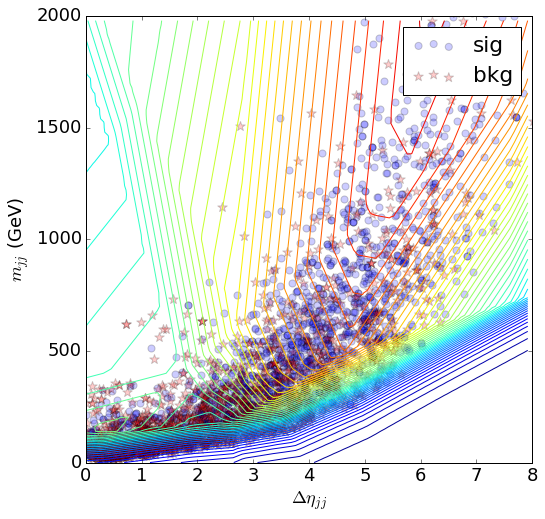

In [31]:
plotResults(dnn, scaler, train_data, test_data)